In [40]:
# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier



In [41]:
# 2. Load datasets
app_df = pd.read_csv("application_record.csv")
credit_df = pd.read_csv("credit_record.csv")

# Display dimensions
print("Application Record shape:", app_df.shape)
print("Credit Record shape:", credit_df.shape)


Application Record shape: (438557, 18)
Credit Record shape: (1048575, 3)


In [42]:
# Show top rows of application data
app_df.head()


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [43]:
# Show first few lines of credit history
credit_df.head()


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [44]:
# 3. Determine bad credit status
# Assume statuses not equal to "0" as risk (poor credit)
credit_df['is_bad'] = credit_df['STATUS'].apply(lambda x: 1 if x != '0' else 0)

# Aggregate by applicant id: max status to indicate if ever had a bad status
agg_status = credit_df.groupby('ID')['is_bad'].max().reset_index()

agg_status.head()

,ID,is_bad
0,5001711,1
1,5001712,1
2,5001713,1
3,5001714,1
4,5001715,1


In [45]:
# 4. Merge datasets on id
data = app_df.merge(agg_status, how='inner', on='ID')

print("Merged dataset shape:", data.shape)


Merged dataset shape: (36457, 19)


In [46]:
data.info()
data.isnull().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

OCCUPATION_TYPE        11323
ID                         0
DAYS_BIRTH                 0
CNT_FAM_MEMBERS            0
FLAG_EMAIL                 0
FLAG_PHONE                 0
FLAG_WORK_PHONE            0
FLAG_MOBIL                 0
DAYS_EMPLOYED              0
NAME_HOUSING_TYPE          0
CODE_GENDER                0
NAME_FAMILY_STATUS         0
NAME_EDUCATION_TYPE        0
NAME_INCOME_TYPE           0
AMT_INCOME_TOTAL           0
CNT_CHILDREN               0
FLAG_OWN_REALTY            0
FLAG_OWN_CAR               0
is_bad                     0
dtype: int64

In [47]:
# Identify features
cat_features = data.select_dtypes(include=['object']).columns.tolist()
num_features = data.select_dtypes(include=['int64','float64']).drop(['ID','is_bad'], axis=1).columns.tolist()

cat_features, num_features


(['CODE_GENDER',
  'FLAG_OWN_CAR',
  'FLAG_OWN_REALTY',
  'NAME_INCOME_TYPE',
  'NAME_EDUCATION_TYPE',
  'NAME_FAMILY_STATUS',
  'NAME_HOUSING_TYPE',
  'OCCUPATION_TYPE'],
 ['CNT_CHILDREN',
  'AMT_INCOME_TOTAL',
  'DAYS_BIRTH',
  'DAYS_EMPLOYED',
  'FLAG_MOBIL',
  'FLAG_WORK_PHONE',
  'FLAG_PHONE',
  'FLAG_EMAIL',
  'CNT_FAM_MEMBERS'])

In [48]:
# Preprocess data
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', cat_transformer, cat_features),
        ('numerical', num_transformer, num_features)
    ]
)


In [49]:
X = data.drop(columns=['is_bad', 'ID'])
y = data['is_bad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (29165, 17)
Test shape: (7292, 17)


In [50]:
#Logistic Regression Pipeline

log_reg = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

log_reg.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical', ...), ('numerical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [51]:
#Radom Forest Pipeline
rf_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(n_estimators=150, random_state=42))
])

rf_clf.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical', ...), ('numerical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [56]:
# Evaluate models

# Logistic Regression
y_pred_lr = log_reg.predict(X_test)

print("Logistic Regression Results")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

Logistic Regression Results
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       856
           1       0.88      1.00      0.94      6436

    accuracy                           0.88      7292
   macro avg       0.44      0.50      0.47      7292
weighted avg       0.78      0.88      0.83      7292

Confusion Matrix:
 [[   0  856]
 [   0 6436]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

In [57]:
#Handle Class Imbalance

y.value_counts(normalize=True)


is_bad
1    0.882547
0    0.117453
Name: proportion, dtype: float64

In [60]:
#Re-implementation of Logistic Regression

log_reg = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(
        max_iter=1000,
        class_weight='balanced'
    ))
])
log_reg.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical', ...), ('numerical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [61]:
#Re-implementation of RANDOM FOREST

rf_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced'
    ))
])
rf_clf.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical', ...), ('numerical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [62]:
#Re-evaluate models
y_pred = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.25      0.38      0.30       856
           1       0.91      0.85      0.88      6436

    accuracy                           0.79      7292
   macro avg       0.58      0.61      0.59      7292
weighted avg       0.83      0.79      0.81      7292

Confusion Matrix:
 [[ 326  530]
 [ 988 5448]]


In [63]:
#Recall-Focused metrics
from sklearn.metrics import roc_auc_score

y_prob = rf_clf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_prob)


0.6661073009299328

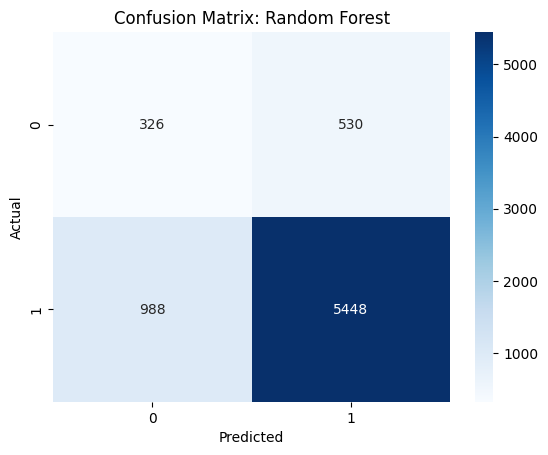

In [65]:
#Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix: Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
